# Forcasting  

In this notebook we will predict the closing prices for the next month

In [55]:
# Import Libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import datetime


In [56]:

# Load the dataset
data = pd.read_csv('./data/cleaned_weekly_stock_market.csv')


In [57]:

# Extract rows for specified companies
companies = ['AMEN BANK', 'ARTES', 'ASSAD', 'BIAT', 'BANQUE DE TUNISIE', 'EURO-CYCLES',
             'SOTUMAG', 'ONE TECH', 'TUNINDEX', 'SAH', 'SFBT', 'SOMOCER', 'SOTETEL',
             'SOTUVER', 'TUNISAIR', 'BANQUE ATTIJARI DE TUNIS', 'TELNET HOLDING', 'TPR', 'UIB']

data_filtered = data[data['companyName'].isin(companies)]


In [58]:

def str_to_datetime(s):
    try:
        return datetime.datetime.strptime(s, '%Y-%m-%d')
    except ValueError:
        return datetime.datetime.strptime(s, '%d/%m/%Y')


In [59]:

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)
    target_date = first_date

    dates = []
    X, Y = [], []
    last_time = False

    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return
        values = df_subset['closingPrice'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        next_date = str_to_datetime(next_date_str)

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df


In [60]:

def windowed_df_to_date_X_y(windowed_df):
    df_as_np = windowed_df.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape(len(dates), middle_matrix.shape[1], 1)
    y = df_as_np[:, -1]
    return dates, X.astype(np.float32), y.astype(np.float32)


In [61]:
def train_and_plot_model(data, company_name):
    n = 3 
    df = data[['date', 'closingPrice']]
    df['date'] = df['date'].apply(str_to_datetime) 
    df.index = df.pop('date')
    
    first_valid_date = df.index[n]
    last_date = df.index[-1]
    windowed_df = df_to_windowed_df(df, first_valid_date.strftime('%Y-%m-%d'), last_date.strftime('%Y-%m-%d'), n=n)
    
    if windowed_df is None:
        return

    dates, X, y = windowed_df_to_date_X_y(windowed_df)

    X_train_val, X_test, y_train_val, y_test, dates_train_val, dates_test = train_test_split(
        X, y, dates, test_size=0.2, random_state=42
    )

    X_train, X_val, y_train, y_val, dates_train, dates_val = train_test_split(
        X_train_val, y_train_val, dates_train_val, test_size=0.25, random_state=42
    )

    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(dates_train, y_train, label='Train')
    plt.plot(dates_val, y_val, label='Validation')
    plt.plot(dates_test, y_test, label='Test')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Train, Validation, and Test Data for {company_name}')
    plt.show()

    model = Sequential([layers.Input(shape=(n, 1)),
                        layers.LSTM(64),
                        layers.Dense(32, activation='relu'),
                        layers.Dense(32, activation='relu'),
                        layers.Dense(1)])
    model.compile(loss='mse',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['mean_absolute_error'])
    model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

    train_pred = model.predict(X_train).flatten()
    val_pred = model.predict(X_val).flatten()
    test_pred = model.predict(X_test).flatten()

    plt.figure(figsize=(12, 6))
    plt.plot(dates_train, train_pred)
    plt.plot(dates_train, y_train)
    plt.plot(dates_val, val_pred)
    plt.plot(dates_val, y_val)
    plt.plot(dates_test, test_pred)
    plt.plot(dates_test, y_test)
    plt.legend(['Training Prediction', 'Training Observation',
                'Validation Prediction', 'Validation Observation',
                'Test Prediction', 'Test Observation'])
    plt.title(f'Predictions and Observations for {company_name}')
    plt.show()


Training and plotting for AMEN BANK


C:\Users\Kahla\AppData\Local\Temp\ipykernel_4752\3041173165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)  # Ensure dates are datetime objects


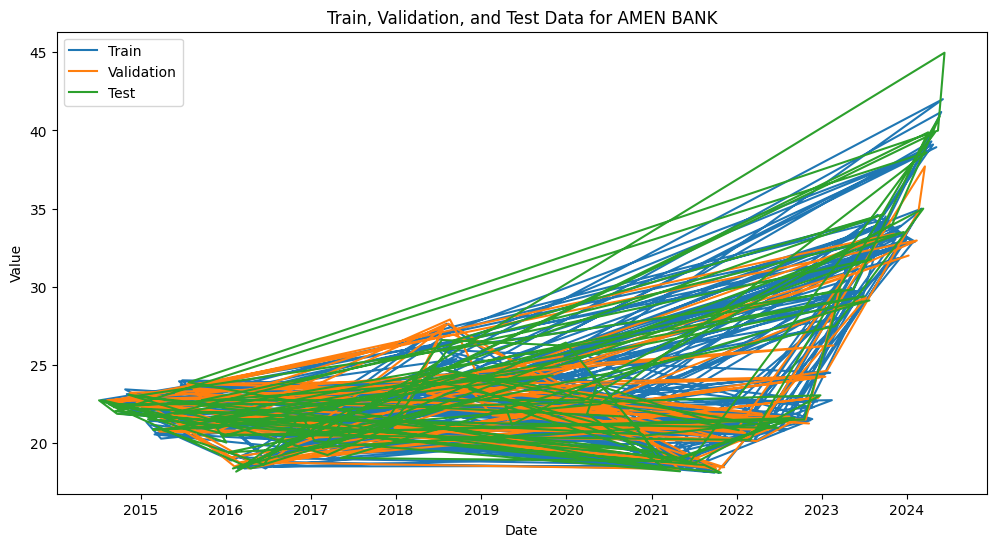

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 555.2817 - mean_absolute_error: 23.0853 - val_loss: 475.4592 - val_mean_absolute_error: 21.5037
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 479.3892 - mean_absolute_error: 21.4901 - val_loss: 418.4720 - val_mean_absolute_error: 20.1321
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 429.1073 - mean_absolute_error: 20.1906 - val_loss: 336.2471 - val_mean_absolute_error: 17.9627
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 327.4826 - mean_absolute_error: 17.5232 - val_loss: 222.8823 - val_mean_absolute_error: 14.4369
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 229.9172 - mean_absolute_error: 14.1361 - val_loss: 92.8923 - val_mean_absolute_error: 8.7978
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 87.0905 - mean_absolute_error: 7.7168 - val_loss: 18.1049 - val_mean_absolute_error: 2.7210
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 26.8994 - 

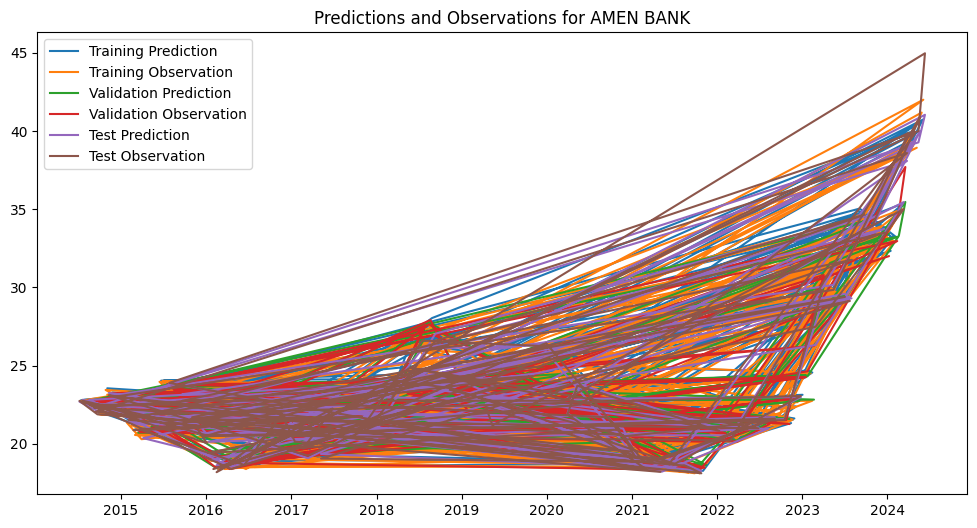

Training and plotting for ARTES


C:\Users\Kahla\AppData\Local\Temp\ipykernel_4752\3041173165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)  # Ensure dates are datetime objects


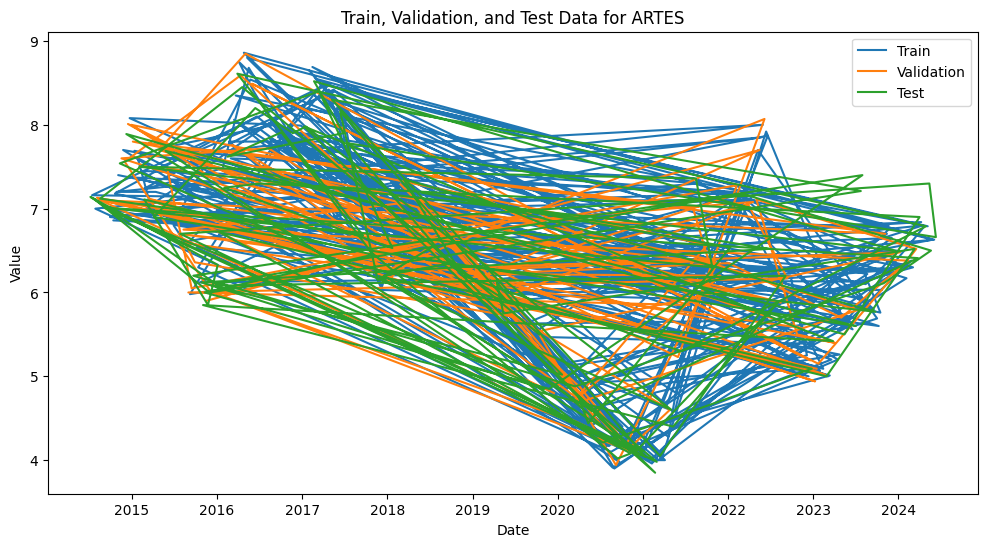

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 44.8869 - mean_absolute_error: 6.5687 - val_loss: 31.8840 - val_mean_absolute_error: 5.5608
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 30.4466 - mean_absolute_error: 5.3913 - val_loss: 21.6868 - val_mean_absolute_error: 4.5695
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19.2750 - mean_absolute_error: 4.2588 - val_loss: 9.3540 - val_mean_absolute_error: 2.9523
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.0298 - mean_absolute_error: 2.4401 - val_loss: 0.8680 - val_mean_absolute_error: 0.7601
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7854 - mean_absolute_error: 0.7148 - val_loss: 1.4116 - val_mean_absolute_error: 1.0447
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3425 - mean_absolute_error: 1.0088 - val_loss: 0.5493 - val_mean_absolute_error: 0.6201
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6834 - mean_absolute_error: 0.7108 - v

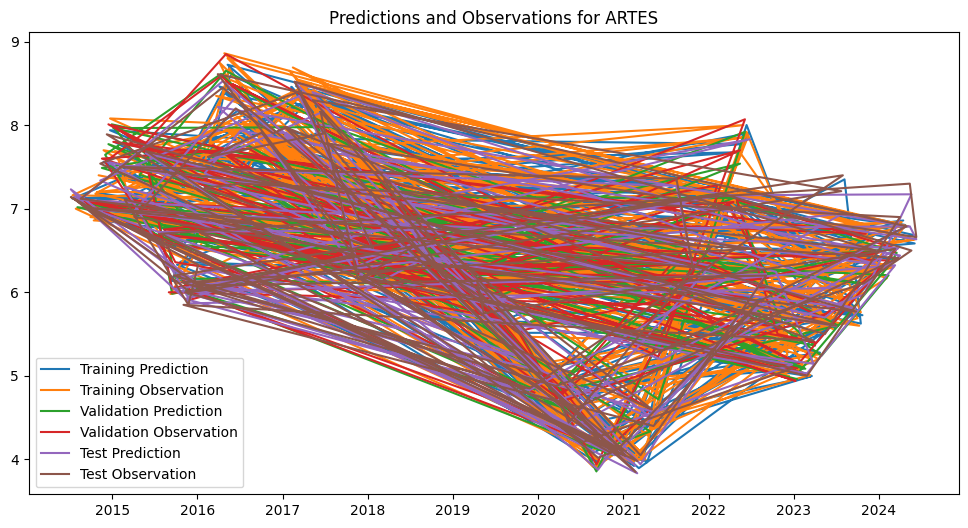

Training and plotting for ASSAD


C:\Users\Kahla\AppData\Local\Temp\ipykernel_4752\3041173165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)  # Ensure dates are datetime objects


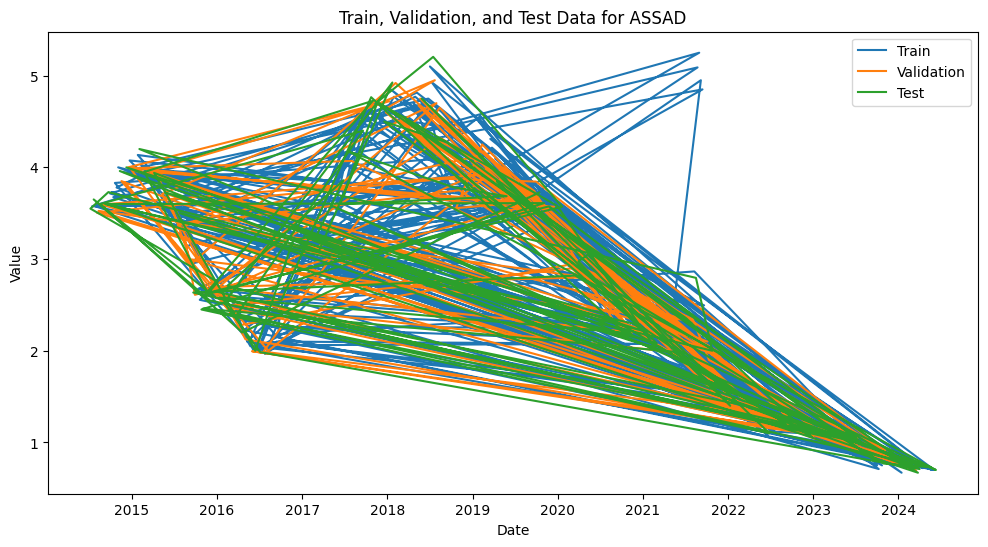

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 8.4192 - mean_absolute_error: 2.6465 - val_loss: 7.2014 - val_mean_absolute_error: 2.4440
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.4955 - mean_absolute_error: 2.3036 - val_loss: 4.4581 - val_mean_absolute_error: 1.8949
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.4351 - mean_absolute_error: 1.6135 - val_loss: 0.8575 - val_mean_absolute_error: 0.7474
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5081 - mean_absolute_error: 0.5162 - val_loss: 0.5580 - val_mean_absolute_error: 0.7060
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4690 - mean_absolute_error: 0.6260 - val_loss: 0.1172 - val_mean_absolute_error: 0.2877
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1749 - mean_absolute_error: 0.3221 - val_loss: 0.1524 - val_mean_absolute_error: 0.3039
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2041 - mean_absolute_error: 0.3120 - v

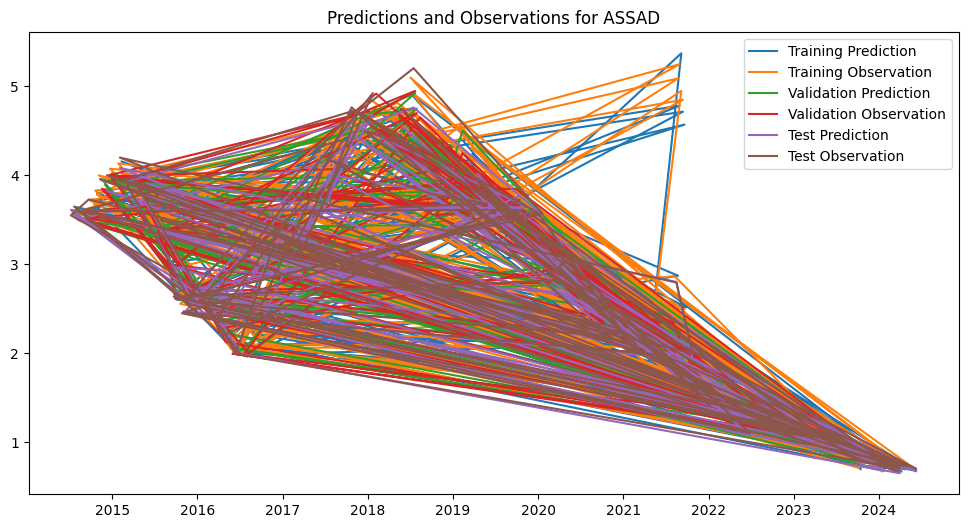

Training and plotting for BIAT


C:\Users\Kahla\AppData\Local\Temp\ipykernel_4752\3041173165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)  # Ensure dates are datetime objects


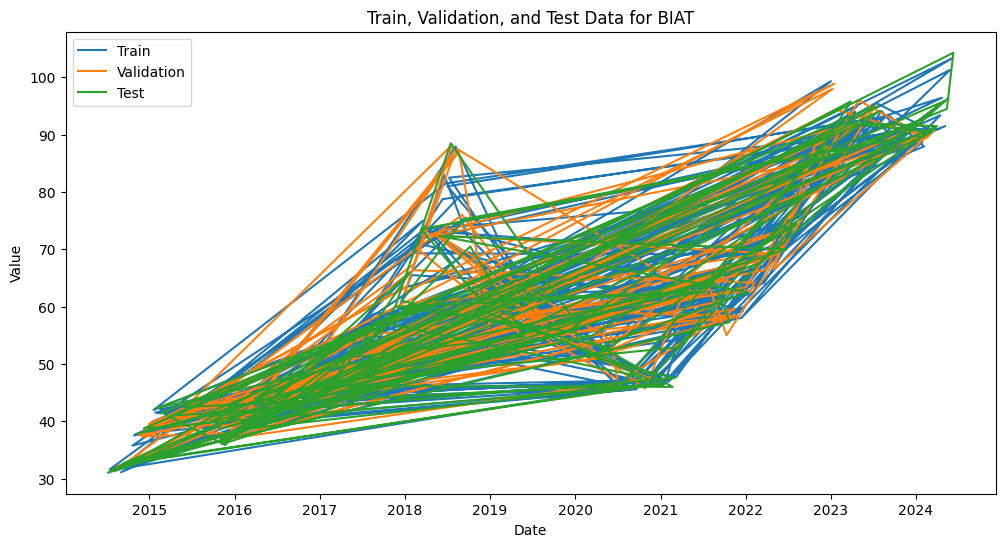

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 3901.0439 - mean_absolute_error: 60.0659 - val_loss: 3784.9275 - val_mean_absolute_error: 58.7794
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3795.8855 - mean_absolute_error: 59.0835 - val_loss: 3657.2517 - val_mean_absolute_error: 57.6660
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3631.5405 - mean_absolute_error: 57.7423 - val_loss: 3482.0674 - val_mean_absolute_error: 56.0913
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3359.2983 - mean_absolute_error: 55.2945 - val_loss: 3221.3257 - val_mean_absolute_error: 53.6228
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3190.2673 - mean_absolute_error: 53.6699 - val_loss: 2772.7903 - val_mean_absolute_error: 49.0510
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2571.0984 - mean_absolute_error: 47.4886 - val_loss: 2036.8600 - val_mean_absolute_error: 40.6159
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - l

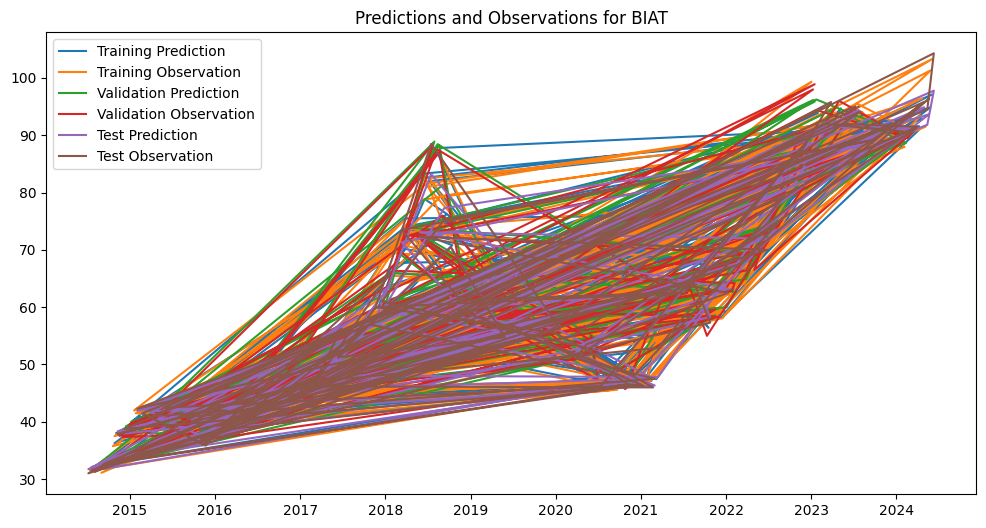

Training and plotting for BANQUE DE TUNISIE


C:\Users\Kahla\AppData\Local\Temp\ipykernel_4752\3041173165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)  # Ensure dates are datetime objects


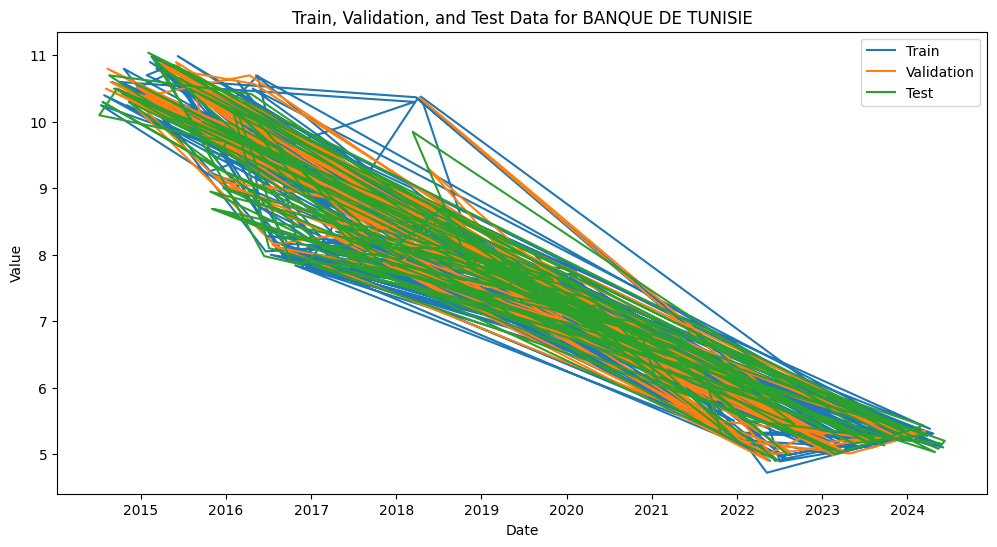

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - loss: 56.4648 - mean_absolute_error: 7.3247 - val_loss: 58.1368 - val_mean_absolute_error: 7.3752
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 50.6996 - mean_absolute_error: 6.9255 - val_loss: 49.0203 - val_mean_absolute_error: 6.7506
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 40.5153 - mean_absolute_error: 6.1416 - val_loss: 35.7722 - val_mean_absolute_error: 5.7137
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 27.0757 - mean_absolute_error: 4.9635 - val_loss: 17.2185 - val_mean_absolute_error: 3.8184
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 10.5224 - mean_absolute_error: 2.8775 - val_loss: 2.8700 - val_mean_absolute_error: 1.3498
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9513 - mean_absolute_error: 1.1218 - val_loss: 3.0598 - val_mean_absolute_error: 1.5644
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.4320 - mean_absolute_error:

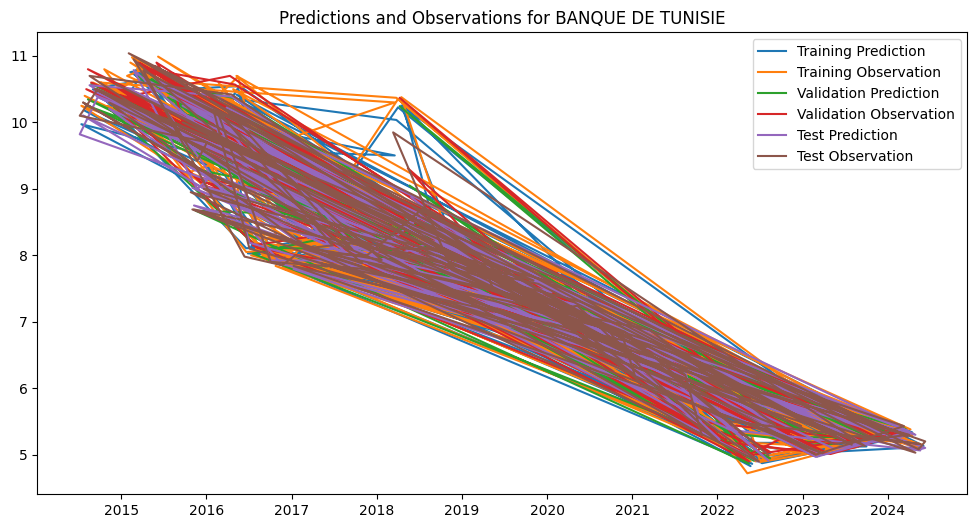

Training and plotting for EURO-CYCLES


C:\Users\Kahla\AppData\Local\Temp\ipykernel_4752\3041173165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)  # Ensure dates are datetime objects


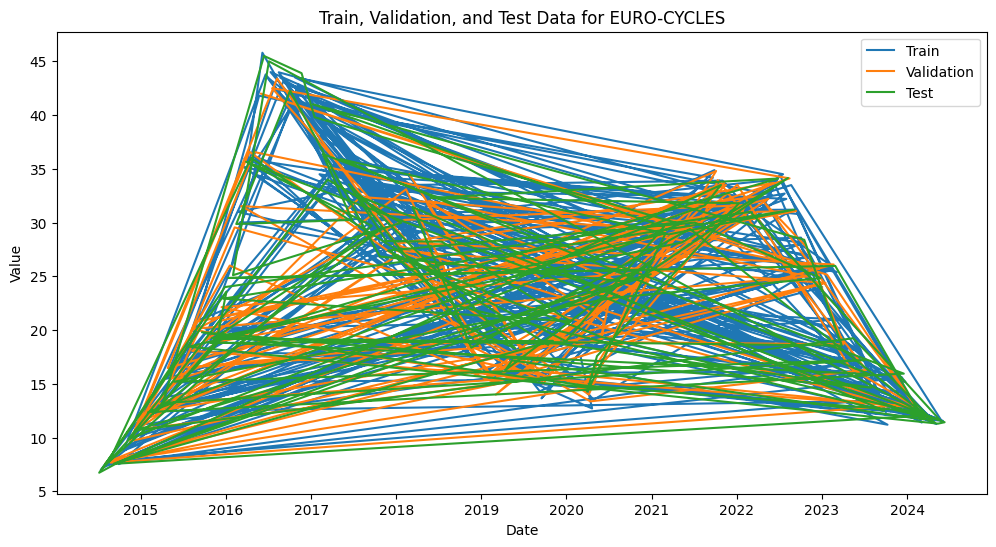

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - loss: 641.1921 - mean_absolute_error: 23.3986 - val_loss: 520.1394 - val_mean_absolute_error: 21.1502
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 603.1581 - mean_absolute_error: 22.4787 - val_loss: 444.5544 - val_mean_absolute_error: 19.2206
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 530.4308 - mean_absolute_error: 20.9213 - val_loss: 332.4816 - val_mean_absolute_error: 15.8919
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 388.5338 - mean_absolute_error: 16.7597 - val_loss: 190.5357 - val_mean_absolute_error: 10.8798
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 232.0246 - mean_absolute_error: 12.1362 - val_loss: 91.2083 - val_mean_absolute_error: 8.2503
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 113.2648 - mean_absolute_error: 9.1006 - val_loss: 94.3913 - val_mean_absolute_error: 8.3766
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 96.3102 

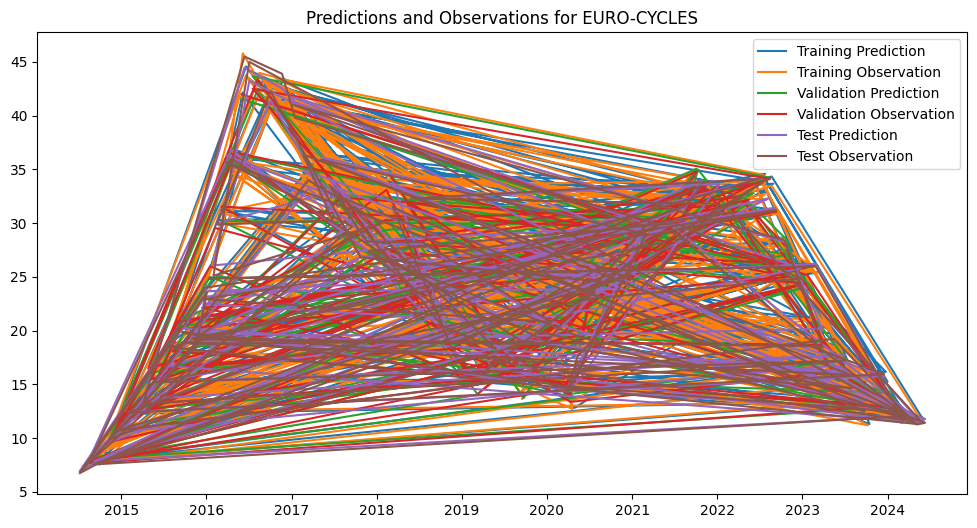

Training and plotting for SOTUMAG


C:\Users\Kahla\AppData\Local\Temp\ipykernel_4752\3041173165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)  # Ensure dates are datetime objects


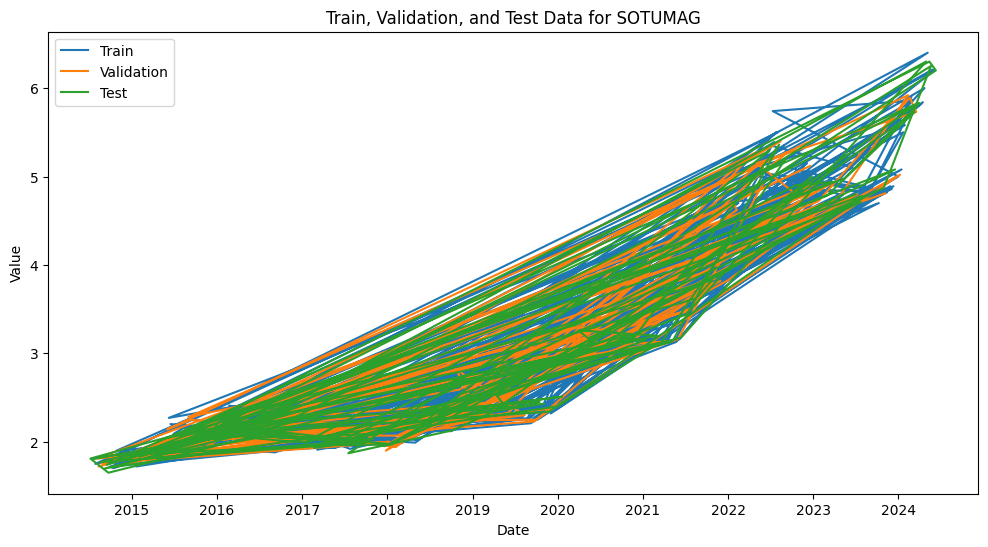

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 9.7382 - mean_absolute_error: 2.8804 - val_loss: 7.1080 - val_mean_absolute_error: 2.4431
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 6.5220 - mean_absolute_error: 2.3217 - val_loss: 3.5383 - val_mean_absolute_error: 1.6731
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.7051 - mean_absolute_error: 1.4191 - val_loss: 0.3933 - val_mean_absolute_error: 0.3855
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3542 - mean_absolute_error: 0.4491 - val_loss: 0.6568 - val_mean_absolute_error: 0.7713
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5001 - mean_absolute_error: 0.6539 - val_loss: 0.1548 - val_mean_absolute_error: 0.3602
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1790 - mean_absolute_error: 0.3463 - val_loss: 0.1616 - val_mean_absolute_error: 0.2797
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1588 - mean_absolute_error: 0.2792 - 

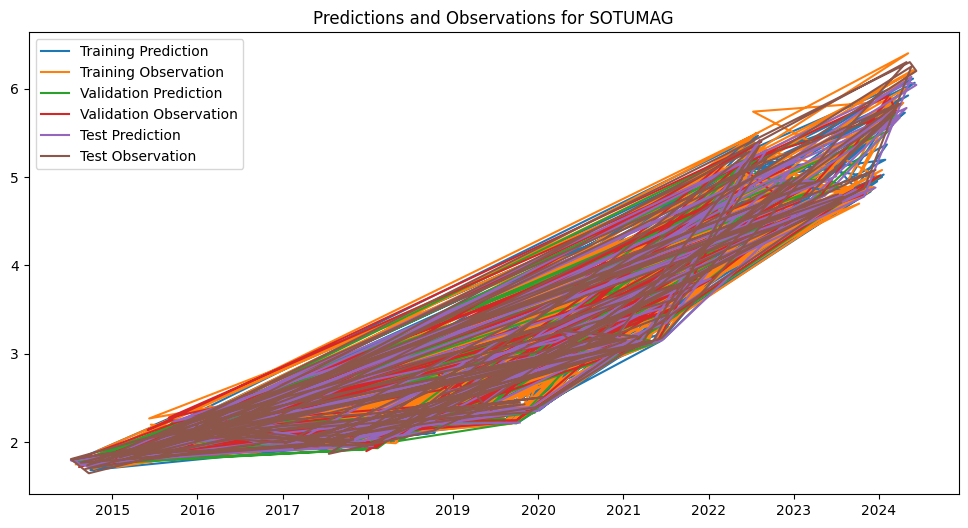

Training and plotting for ONE TECH


C:\Users\Kahla\AppData\Local\Temp\ipykernel_4752\3041173165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)  # Ensure dates are datetime objects


In [62]:

# Apply the model for each company
for company in companies:
    company_data = data_filtered[data_filtered['companyName'] == company]
    if not company_data.empty:
        print(f'Training and plotting for {company}')
        train_and_plot_model(company_data, company)
    else:
        print(f'No data available for {company}')
